In [1]:
import pandas as pd
# Load centrality data
centrality_df = pd.read_excel("data/Centrality_indices.xlsx")

In [2]:
import importlib
import codes.extract_backbone

importlib.reload(codes.extract_backbone)
from codes.extract_backbone import extract_backbone_from_files_brazil

backbone_df = extract_backbone_from_files_brazil(
    centrality_path="data/Centrality_indices.xlsx",
    mobility_edges_path="data/Road_and_waterway_connections_database_2016.xlsx",
    alpha=0.01
)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df[['source', 'target', 'weekly_flow', 'pij']].head())


[✓] Backbone file found at 'data/mobility_backbone_brazil.csv'. Loading it...
Backbone extracted with 20057 edges
    source   target  weekly_flow       pij
0  1302603  1304260          7.5  0.624295
1  1302108  1302603          3.0  0.678201
2  5103809  5108402          0.0  1.000000
3  1300029  1302603          7.5  0.732111
4  1300029  1301308          6.0  0.728335


In [3]:
import numpy as np
from codes.load_and_save_covid_data import load_and_save_covid_data

covid_df = load_and_save_covid_data()

print(f"Full date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Total records: {len(covid_df):,}")

negative_counts = (covid_df.select_dtypes(include=[np.number]) < 0).sum()
print("📉 Negative values per column:")
print(negative_counts[negative_counts > 0])


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Full date range: 2020-02-25 00:00:00 to 2023-03-18 00:00:00
Total records: 5,830,987
📉 Negative values per column:
newDeaths                          16629
deaths                               186
newCases                           63752
totalCases                           278
deaths_per_100k_inhabitants          186
totalCases_per_100k_inhabitants      278
dtype: int64


In [4]:
from codes.preprocess_covid_brazil import filter_and_scale_covid_by_centrality

filtered_scaled_covid_df = filter_and_scale_covid_by_centrality(covid_df)

[✓] Found saved preprocessed COVID data at 'data/filtered_scaled_covid.csv'. Loading...


In [5]:
from codes.graph_utils import build_pyg_graph_from_backbone

pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)
print(pyg_data)

[✓] Graph built with 5386 nodes and 20057 edges.
[✓] Converted to PyTorch Geometric format.
Data(edge_index=[2, 40114], name=[5386], weight=[40114], edge_attr=[40114, 1], num_nodes=5386)


In [6]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [7]:
import importlib
import codes.data_utils

importlib.reload(codes.data_utils)

from codes.data_utils import prepare_temporal_graph_data_non_overlapping, generate_sliding_temporal_graph_data, \
    prepare_temporal_graph_data_non_overlapping

# Traditional (non-sliding) approach
X_train_static, X_test_static, Y_train_static, Y_test_static = prepare_temporal_graph_data_non_overlapping(
    filtered_scaled_covid_df,
    sequence_length=15,
    feature_column="z_newCases",
    device=device
)

# Sliding window approach
X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    filtered_scaled_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device
)

Y_train_slide = Y_train_slide.squeeze(1)
print(Y_train_slide.shape)

Y_test_slide = Y_test_slide.squeeze(1)
print(Y_test_slide.shape)

# Compare number of samples
total_static = len(X_train_static) + len(X_test_static)
total_slide = len(X_train_slide) + len(X_test_slide)

print("📊 Sample Count Comparison")
print(f"Static window (15 input, 1 output): {total_static} samples")
print(f"Sliding window (10 input, 1 output): {total_slide} samples")
print(f"⬆️ Gain: {total_slide - total_static} samples (+{100 * (total_slide - total_static) / total_static:.2f}%)")


[📉] (Non-overlapping) X shape: torch.Size([69, 15, 5386, 1]) | Y shape: torch.Size([69, 5386, 1])
[📉] Train: torch.Size([55, 15, 5386, 1]) | Test: torch.Size([14, 15, 5386, 1])
[✓] Sliding window: X torch.Size([1104, 14, 5386, 1]), Y torch.Size([1104, 1, 5386, 1])
[✓] Train: torch.Size([883, 14, 5386, 1]), Test: torch.Size([221, 14, 5386, 1])
torch.Size([883, 5386, 1])
torch.Size([221, 5386, 1])
📊 Sample Count Comparison
Static window (15 input, 1 output): 69 samples
Sliding window (10 input, 1 output): 1104 samples
⬆️ Gain: 1035 samples (+1500.00%)


In [8]:
import importlib
import codes.models.custom_gcrn_transformer
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcrn_transformer)

from codes.models.custom_gcrn_transformer import GCRNWithTransformer

model = GCRNWithTransformer(in_channels=1, hidden_channels=64, out_channels=1).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # reduce LR by half every 5 epochs

In [9]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [10]:
batch_size = 32  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
from tqdm import tqdm

edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        optimizer.zero_grad()
        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.6f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"🧠 Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")
    
    scheduler.step()

🧠 Epoch 1/10 — Avg Loss: 0.9925


🧠 Epoch 2/10 — Avg Loss: 0.9119


🧠 Epoch 3/10 — Avg Loss: 0.8952


🧠 Epoch 4/10 — Avg Loss: 0.9030


🧠 Epoch 5/10 — Avg Loss: 0.8876


🧠 Epoch 6/10 — Avg Loss: 0.8889


🧠 Epoch 7/10 — Avg Loss: 0.8858


🧠 Epoch 8/10 — Avg Loss: 0.8794


🧠 Epoch 9/10 — Avg Loss: 0.8821


🧠 Epoch 10/10 — Avg Loss: 0.8792


In [12]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.4916


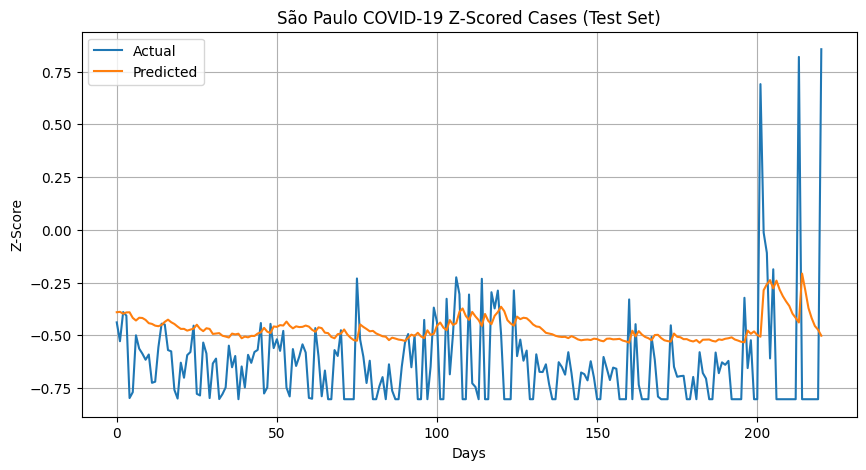

📉 RMSE for São Paulo: 0.2851


In [16]:
import matplotlib.pyplot as plt
import networkx as nx

G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# São Paulo IBGE code
sp_code = 3550308
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)

sp_preds = pred_array[:, sp_index]
sp_actuals = actual_array[:, sp_index]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual')
plt.plot(sp_preds, label='Predicted')
plt.title("São Paulo COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()


from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for São Paulo: {rmse_sp:.4f}")



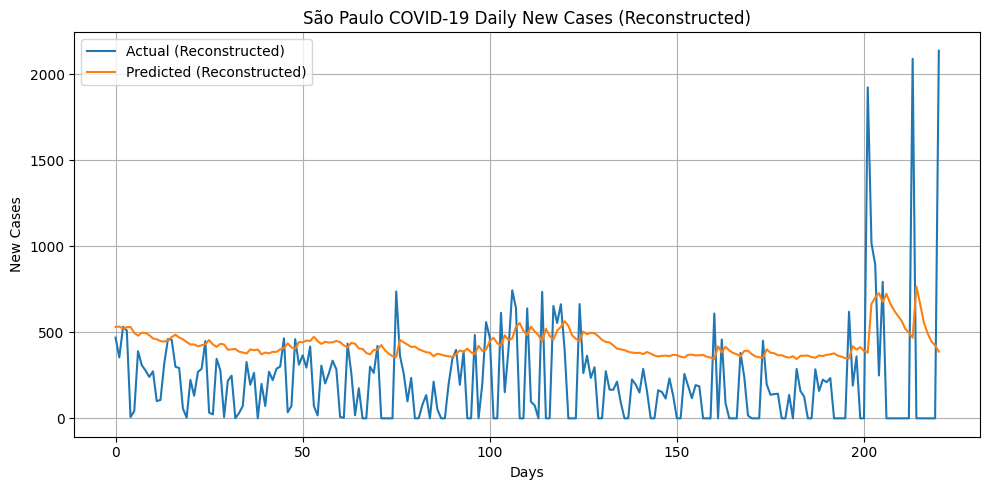

📉 RMSE for São Paulo (Reconstructed): 367.19


In [14]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# São Paulo IBGE code
sp_code = 3550308
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)


sp_preds_z = pred_array[:, sp_index]
sp_actuals_z = actual_array[:, sp_index]

# 🧠 Get mean and std from original covid_df
sp_original = covid_df[covid_df['ibgeID'] == sp_code].copy()
sp_original['newCases'] = sp_original['newCases'].clip(lower=0)
sp_original = sp_original.sort_values('date')
mean_sp = sp_original['newCases'].mean()
std_sp = sp_original['newCases'].std(ddof=0)

# 🔁 Reconstruct original values
sp_preds = sp_preds_z * std_sp + mean_sp
sp_actuals = sp_actuals_z * std_sp + mean_sp

# 📈 Plot reconstructed
plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual (Reconstructed)')
plt.plot(sp_preds, label='Predicted (Reconstructed)')
plt.title("São Paulo COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 RMSE in original scale
rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for São Paulo (Reconstructed): {rmse_sp:.2f}")


In [17]:
# Filter São Paulo full series
sp_full = filtered_scaled_covid_df[filtered_scaled_covid_df['ibgeID'] == sp_code].sort_values('date')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['date'].tolist()


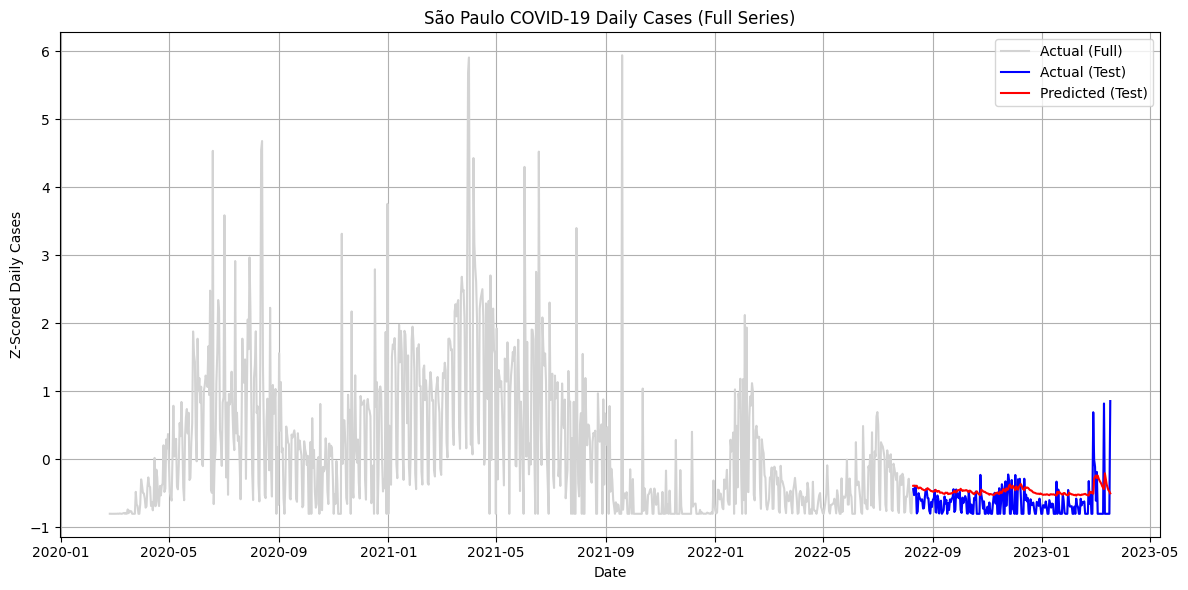

In [18]:
# Find index where test set starts (80% of the full time series segments)
start_index = len(full_z_series) - len(sp_actuals)

plt.figure(figsize=(12, 6))
plt.plot(full_dates, full_z_series, label='Actual (Full)', color='lightgray')
plt.plot(full_dates[start_index:], sp_actuals, label='Actual (Test)', color='blue')
plt.plot(full_dates[start_index:], sp_preds, label='Predicted (Test)', color='red')
plt.title("São Paulo COVID-19 Daily Cases (Full Series)")
plt.xlabel("Date")
plt.ylabel("Z-Scored Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")


📊 Average RMSE across all cities: 0.5215


In [20]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: 2611606 — RMSE: 2.2318
City ID: 2607901 — RMSE: 2.2259
City ID: 2604106 — RMSE: 2.2209
City ID: 2611101 — RMSE: 2.2197
City ID: 2606200 — RMSE: 2.2145

✅ Top 5 cities with lowest RMSE:
City ID: 2924405 — RMSE: 0.0664
City ID: 1709807 — RMSE: 0.0673
City ID: 1715705 — RMSE: 0.0673
City ID: 1718303 — RMSE: 0.0675
City ID: 2409100 — RMSE: 0.0679


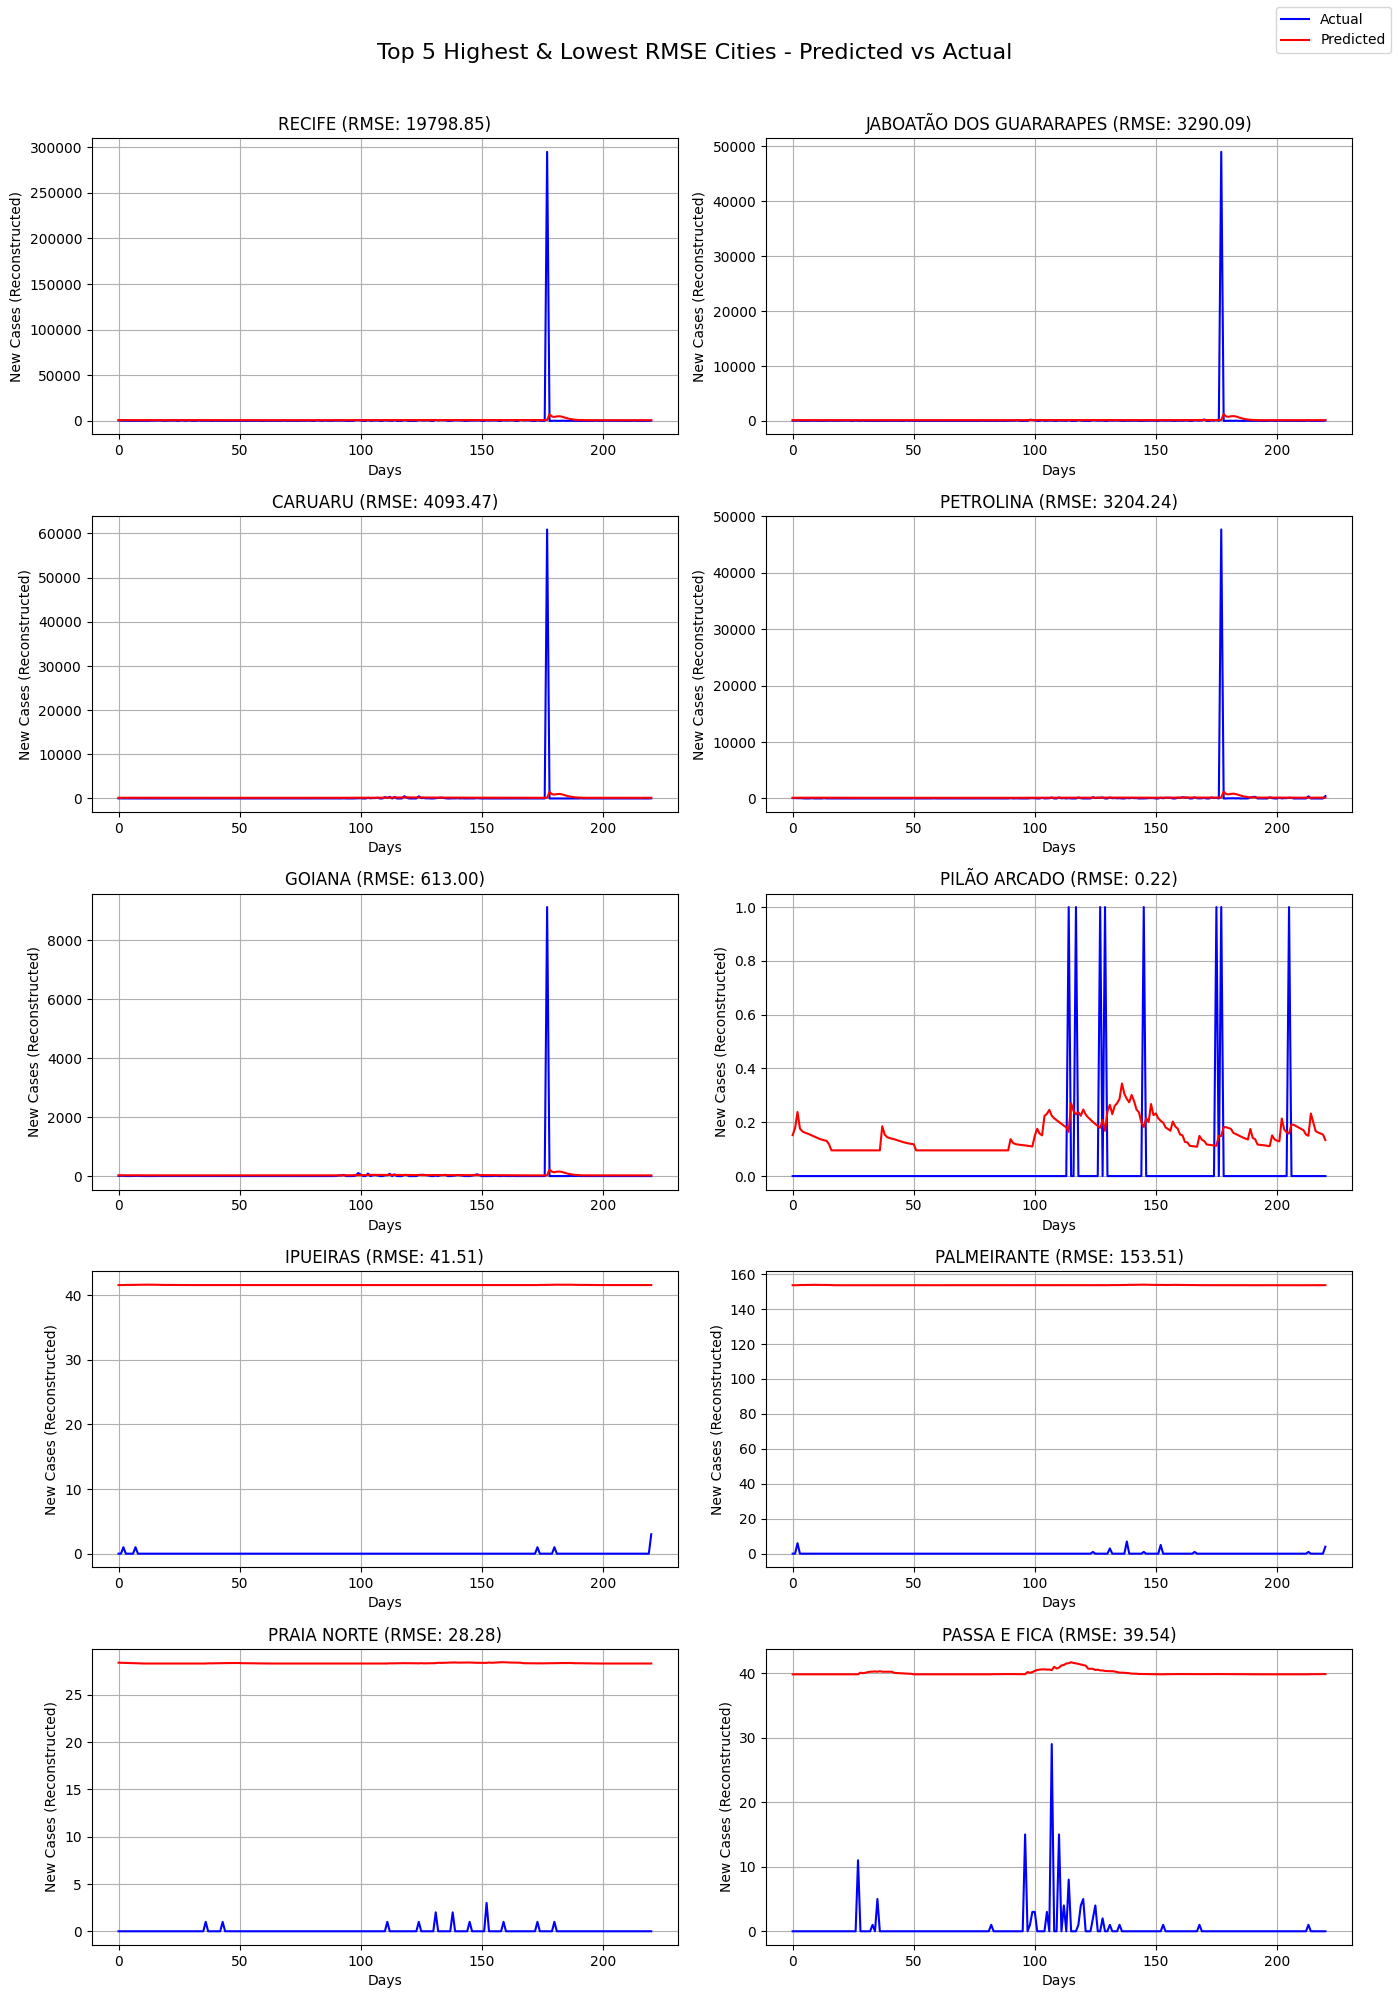

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = covid_df[covid_df['ibgeID'] == city_id].copy()
    city_data['newCases'] = city_data['newCases'].clip(lower=0)
    mean = city_data['newCases'].mean()
    std = city_data['newCases'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [23]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/GCRN-Transformer-FINAL-NOT-BEST.pth")